In [1]:
import os
import gc
import glob
import math
import random
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils

import albumentations as A
from albumentations.pytorch import ToTensorV2

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/rangerdeeplearningoptimizer/ranger')
import timm
import wandb
from ranger import Ranger

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
class Mish_layer(nn.Module):
    '''
    The class defines the Mish activation function.
    '''
    def __init__(self):
        super(Mish_layer,self).__init__()
    def forward(self,x):
        return x*torch.tanh(F.softplus(x))

In [3]:
def set_seed(seed):
    #Sets the seed for Reprocudibility
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        
set_seed(7)

In [4]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb") 

wandb.login(key = wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
config = dict(
    batch_size = 256,
    epochs = 100,
    learning_rate = 3e-4
    )

In [6]:
def img_paths_list(root_dir):
    root_list = glob.glob(root_dir)

    data = []
    for img_path in tqdm(root_list):
        data.append(img_path)
        
    return data

In [7]:
data_root_dir = r'../input/gsocml4scimodel2/Model_II/no_sub/*'
dataset_img_paths_list = img_paths_list(data_root_dir)

test_data_root_dir = r'../input/gsocml4scimodel2test/Model_II_test/no_sub/*'
test_paths_list = img_paths_list(test_data_root_dir)

# #this file was not being read by numpy
# dataset_img_paths_list.remove('../input/gsocml4scimodel8or9/reg_axion/sim_10205913971171895758427970222342137331.npy')

  0%|          | 0/29449 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
val_split = int(0.07 * len(dataset_img_paths_list))

random.shuffle(dataset_img_paths_list)

val_paths_list = dataset_img_paths_list[:val_split]
train_paths_list = dataset_img_paths_list[val_split:]

assert len(dataset_img_paths_list) == (len(train_paths_list) + len(val_paths_list))

len(train_paths_list), len(val_paths_list), len(test_paths_list)

(27388, 2061, 5000)

In [9]:
train_transforms = A.Compose(
            [
#                 A.CenterCrop(height = 50, width = 50, p = 1.0),
                A.HorizontalFlip(p = 0.5),
                A.VerticalFlip(p = 0.5),
                A.Rotate(limit = 360, p = 0.4),
                ToTensorV2()
            ]
        )


test_transforms = A.Compose(
            [
#                 A.CenterCrop(height = 50, width = 50, p = 1.0),
                ToTensorV2()
            ]
        )

In [10]:
def pickelize_file(dicto, pickle_path):
    file_to_write = open(pickle_path, "wb")
    pickle.dump(dicto, file_to_write)
    
    print("Pickleized successfully!")
    
pickelize_file(train_paths_list, "train_paths_list.pickle")
pickelize_file(val_paths_list, "val_paths_list.pickle")

Pickleized successfully!
Pickleized successfully!


In [11]:
class CustomDataset(Dataset):
    def __init__(self, paths_list, transform = None):

        self.transform = transform
        self.data = paths_list
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        path = self.data[idx]
        img = np.load(path, allow_pickle = True)
        img = (img - np.min(img))/(np.max(img) - np.min(img))

       
        if self.transform:
            aug = self.transform(image = img)
            img = aug['image']
        
        img = img.to(torch.float)        

        return img

In [12]:
train_dataset = CustomDataset(train_paths_list, transform = train_transforms)
print(len(train_dataset))

val_dataset = CustomDataset(val_paths_list, transform = test_transforms)
print(len(val_dataset))

test_dataset = CustomDataset(test_paths_list, transform = test_transforms)
print(len(test_dataset))

27388
2061
5000


In [13]:
train_loader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle = True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = config['batch_size'], shuffle = False, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False, num_workers = 2)

In [14]:
single_batch = next(iter(train_loader))
single_batch.shape

torch.Size([256, 1, 64, 64])

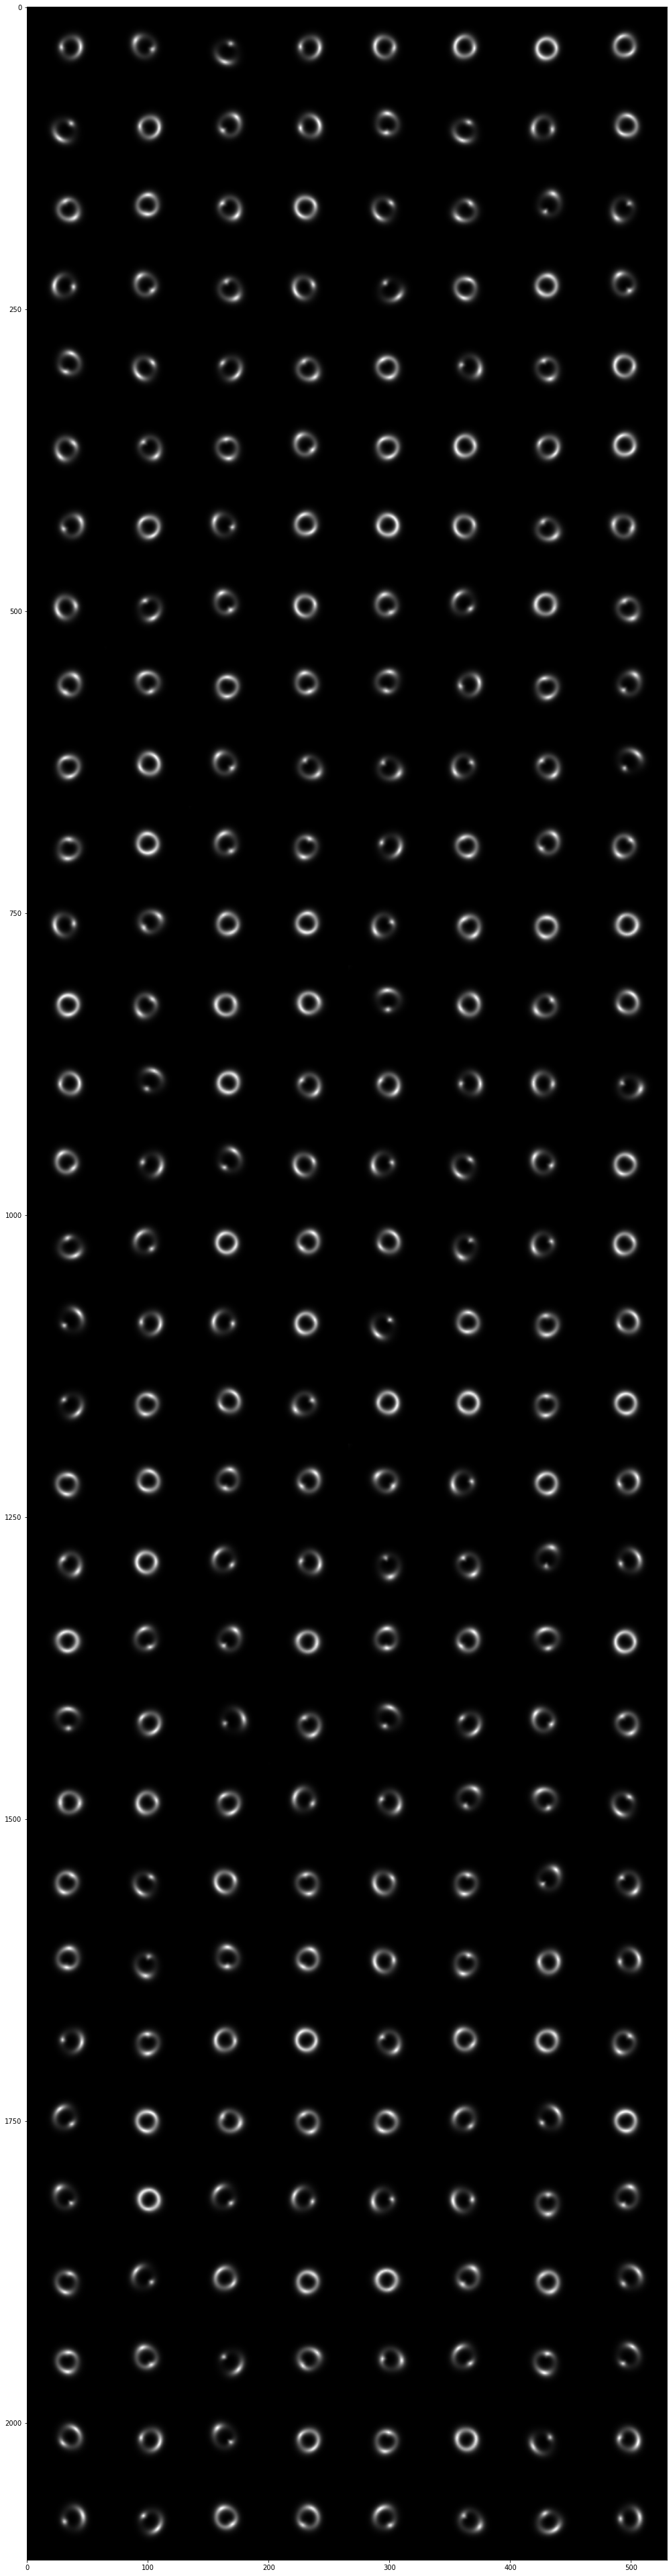

In [15]:
single_batch_grid = utils.make_grid(single_batch, nrow=8)
plt.figure(figsize = (20,70))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [16]:
class Encoder(nn.Module):
    
    def __init__(self, in_channels = 1, latent_dim = 2048):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size=2, stride = 2),
            nn.BatchNorm2d(64),
            Mish_layer(),

            nn.Conv2d(64, 32, 2, stride=1),
            nn.BatchNorm2d(32),
            Mish_layer(),
            
            nn.Conv2d(32, 16, 2, stride=1),
            nn.BatchNorm2d(16),
            Mish_layer(),
            
            nn.Conv2d(16, 8, 2, stride=1),
            nn.BatchNorm2d(8),
            Mish_layer()
        )


        self.bottleneck = nn.Sequential(
            nn.Linear(6728, latent_dim),
            Mish_layer()
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = x.view(x.shape[0],-1)
        x = self.bottleneck(x)
        return x

In [17]:
    
class Decoder(nn.Module):
    
    def __init__(self, out_channels = 1, latent_dim = 2048):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dim, 6728),
            Mish_layer()
        )

        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 2, stride = 1),
            nn.BatchNorm2d(16),
            Mish_layer(),
            
            nn.ConvTranspose2d(16, 32, 2, stride = 1),
            nn.BatchNorm2d(32),
            Mish_layer(),

            nn.ConvTranspose2d(32, 64, 2, stride = 1),
            nn.BatchNorm2d(64),
            Mish_layer(),
            
            nn.ConvTranspose2d(64, out_channels, 2, stride = 2),
#             nn.UpsamplingBilinear2d(size=(256,256))
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = x.view(x.shape[0], 8, 29, 29)
        x = self.decoder_conv(x)
#         x = torch.sigmoid(x)
        return x

In [18]:
x = torch.randn(config["batch_size"], 1, 64, 64)

enc = Encoder()
dec = Decoder()

latent = enc(x)
print(x.shape)
print(latent.shape)
print(dec(latent).shape)


del enc,dec, latent, x
gc.collect()

torch.Size([256, 1, 64, 64])
torch.Size([256, 2048])
torch.Size([256, 1, 64, 64])


188

In [19]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder(in_channels = 1)
        self.decoder = Decoder(out_channels = 1)

    def forward(self,x):
        encoded = self.encoder(x)
        z = self.decoder(encoded)

        return z

In [20]:
x = torch.randn(config["batch_size"], 1, 64, 64).to(device)
model = Autoencoder().to(device)
print(model(x).shape)

del model, x 
gc.collect()

torch.Size([256, 1, 64, 64])


0

In [21]:
def train_epoch(model, dataloader, criterion, optimizer, example_ct):
    
    model.train()
    train_loss = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, img_batch in loop:

        X = img_batch.to(device)

        example_ct += len(img_batch)
        
        #forward prop
        y_pred = model(X)
        
        #loss calculation
        loss = criterion(y_pred, X) 
#         loss = ((y_pred - X)**2).sum() + model.encoder.kl

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return model, np.mean(train_loss), example_ct

In [22]:
def test_epoch(model, dataloader,criterion):

    model.eval()
    losses = []
    
    y_pred_list = []
    y_truth_list = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, img_batch in loop:
            X = img_batch.to(device)
            y_truth_list.append(X.detach().cpu().numpy())

            #forward prop
            y_pred = model(X)
            
            y_pred_list.append(y_pred.detach().cpu().numpy())

            #loss and accuracy calculation
            loss = criterion(y_pred, X) 
#             loss = ((y_pred - X)**2).sum() + model.encoder.kl


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            losses.append(loss.detach().cpu().numpy())

            
    return y_pred_list, y_truth_list, np.mean(losses)

In [23]:
def plot_ae_outputs(model,dataset,epoch, n = 10):
    
    model.eval()
    plt.figure(figsize=(16,4.5))
    random_index = random.randint(0,len(dataset) - (n + 1)) 
    
    
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = dataset[random_index + i].unsqueeze(0).to(device)


        with torch.no_grad():
            rec_img = model(img)
            
        img = img.permute(0,2,3,1)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
            
        ax = plt.subplot(2, n, i + 1 + n)
        rec_img = rec_img.permute(0,2,3,1)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
            
    plot_name = f"Reconstructions"
    plt.savefig(plot_name, format="png", dpi=80)  
    pic = Image.open(plot_name)
    
    wandb.log({plot_name: [wandb.Image(pic, caption = f"Epoch : {epoch+1}")]})
            
    plt.show()   

In [24]:
def fit_model(model, config):
    
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        EPOCHS = config.epochs
        LR = config.learning_rate
        optimizer = Ranger(model.parameters(), lr = LR)
#         scheduler = CosineAnnealingWarmRestarts(optimizer,T_0 = 10, T_mult = 1,eta_min = 1e-6, verbose=True)
        criterion = nn.MSELoss()

        loss_dict = {'train_loss':[],'val_loss':[]}
        example_ct = 0  # number of examples seen

        wandb.watch(model, criterion, log="all", log_freq = 10)
        for epoch in range(EPOCHS):
            print(f"Epoch {epoch+1}/{EPOCHS}:")
            model, train_loss, example_ct = train_epoch(model, train_loader, criterion, optimizer, example_ct)
            _, _, val_loss = test_epoch(model, val_loader, criterion)
#             scheduler.step()

            print(f'Train loss:{train_loss}, Val loss:{val_loss}')
            wandb.log({"epoch": epoch + 1, "train_loss":train_loss, "val_loss": val_loss}, step = example_ct)

            loss_dict['train_loss'].append(train_loss)
            loss_dict['val_loss'].append(val_loss)

            if epoch % 5 == 0 or epoch + 1 == EPOCHS:
                plot_ae_outputs(model, val_dataset, epoch,10)


        return model, loss_dict

In [25]:
wandb.init(project="gsoc_model2-AD", config = config)

wandb: Currently logged in as: saranga7. Use `wandb login --relogin` to force relogin


In [26]:
model = Autoencoder().to(device)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Epoch 1/100:


  0%|          | 0/107 [00:00<?, ?it/s]

../input/rangerdeeplearningoptimizer/ranger/ranger.py:138: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/python_arg_parser.cpp:1055.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:1.571657657623291, Val loss:0.686722457408905


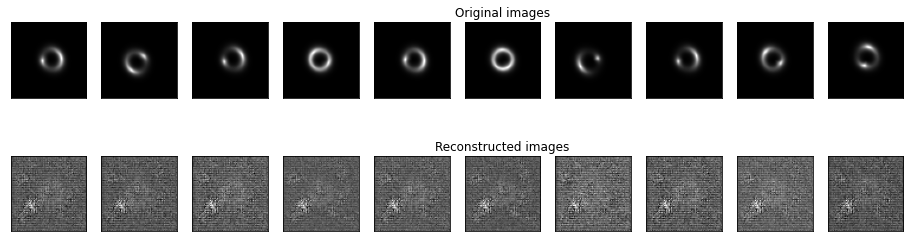

Epoch 2/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.32787129282951355, Val loss:0.15900258719921112
Epoch 3/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.08821028470993042, Val loss:0.05755554139614105
Epoch 4/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.03487028181552887, Val loss:0.023294292390346527
Epoch 5/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.013744235038757324, Val loss:0.008947568014264107
Epoch 6/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.005985117983072996, Val loss:0.004195823334157467


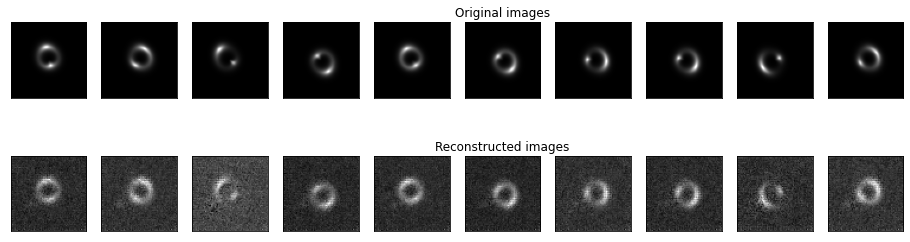

Epoch 7/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.003364053787663579, Val loss:0.002535755978897214
Epoch 8/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0023066746070981026, Val loss:0.0017947735032066703
Epoch 9/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0018051593797281384, Val loss:0.001502352999523282
Epoch 10/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0015188410179689527, Val loss:0.0011580133577808738
Epoch 11/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0013166627613827586, Val loss:0.0012198262847959995


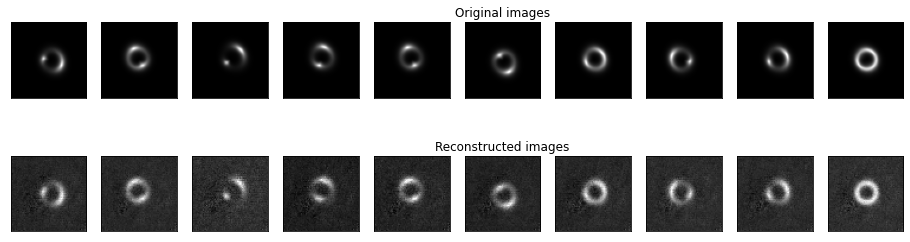

Epoch 12/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0011410217266529799, Val loss:0.0008262679330073297
Epoch 13/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0010410456452518702, Val loss:0.0008908153395168483
Epoch 14/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0009319395176135004, Val loss:0.0006941683823242784
Epoch 15/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.000852444558404386, Val loss:0.0008075335645116866
Epoch 16/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0008337278268299997, Val loss:0.0005394835025072098


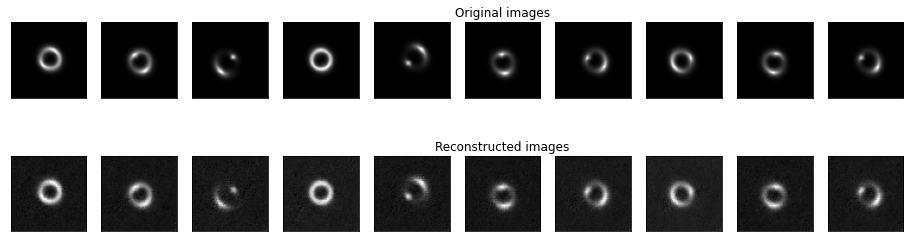

Epoch 17/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0007191970362327993, Val loss:0.0007213196950033307
Epoch 18/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0006987717351876199, Val loss:0.00044307191274128854
Epoch 19/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.000640951911918819, Val loss:0.0005735313170589507
Epoch 20/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0006251041777431965, Val loss:0.0004096419725101441
Epoch 21/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00056660664267838, Val loss:0.0006331662298180163


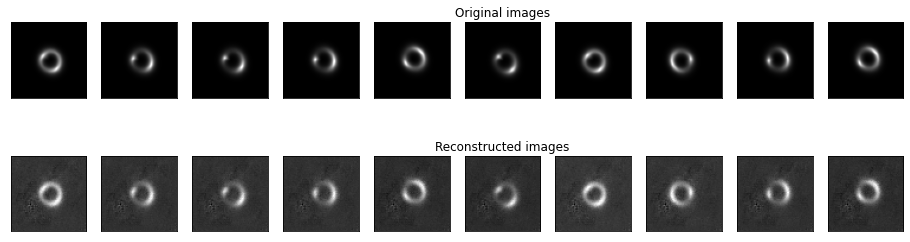

Epoch 22/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0005502876010723412, Val loss:0.00034575595054775476
Epoch 23/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0005157351843081415, Val loss:0.0005801117513328791
Epoch 24/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00047757019638083875, Val loss:0.0002823084651026875
Epoch 25/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00045465343282558024, Val loss:0.0004871322598773986
Epoch 26/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0004773385007865727, Val loss:0.0003505905042402446


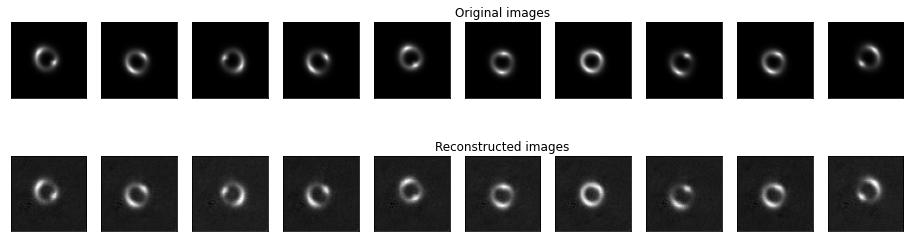

Epoch 27/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0004367777146399021, Val loss:0.0005727803218178451
Epoch 28/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.000416489812778309, Val loss:0.0002612610114738345
Epoch 29/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00036765026743523777, Val loss:0.0004358061996754259
Epoch 30/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00037642521783709526, Val loss:0.0002402422105660662
Epoch 31/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00039919521077536047, Val loss:0.00038305966882035136


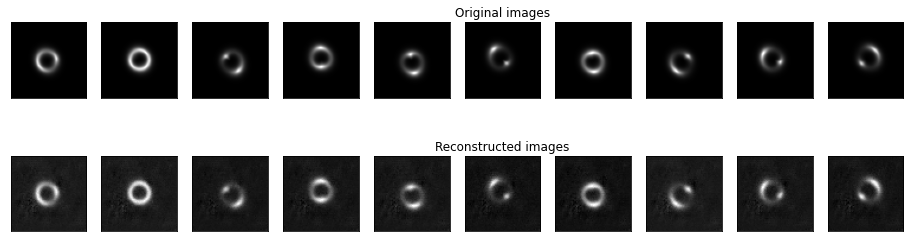

Epoch 32/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0003306102298665792, Val loss:0.00022875776630826294
Epoch 33/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00036514291423372924, Val loss:0.00032440698123537004
Epoch 34/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00028991419821977615, Val loss:0.0002204153424827382
Epoch 35/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0003390065103303641, Val loss:0.0003954382846131921
Epoch 36/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0003105533542111516, Val loss:0.00015863700537011027


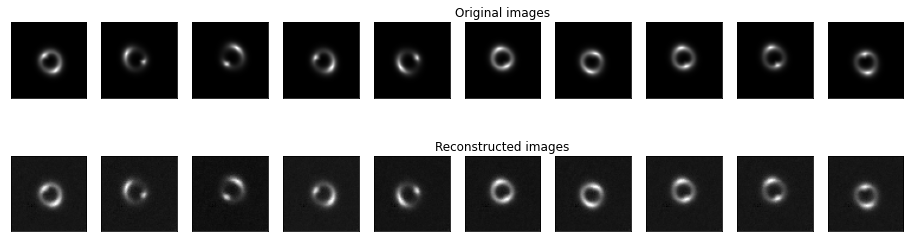

Epoch 37/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0003238180943299085, Val loss:0.00028983503580093384
Epoch 38/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0002865214482881129, Val loss:0.00019906388479284942
Epoch 39/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0002608708164189011, Val loss:0.00028402122552506626
Epoch 40/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0002935434167739004, Val loss:0.000237245112657547
Epoch 41/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0002709408290684223, Val loss:0.0003335603978484869


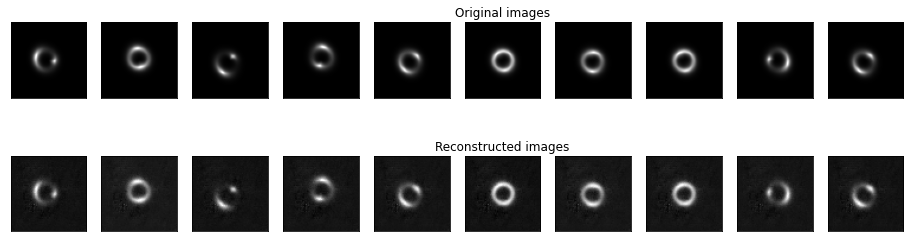

Epoch 42/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0002463203272782266, Val loss:0.00013756356202065945
Epoch 43/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0002406566054560244, Val loss:0.00020839735225308686
Epoch 44/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00025119201745837927, Val loss:0.00014860916417092085
Epoch 45/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00022860783792566508, Val loss:0.0002500583359505981
Epoch 46/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00021737140195909888, Val loss:0.00026079313829541206


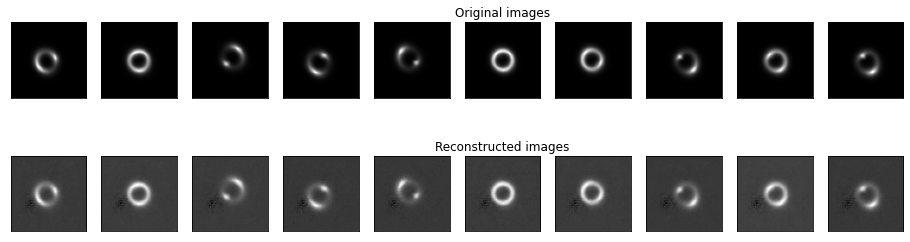

Epoch 47/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.000244198483414948, Val loss:0.0002169532817788422
Epoch 48/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00020472936739679426, Val loss:0.00011693515261868015
Epoch 49/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0002059412217931822, Val loss:0.0002213636034866795
Epoch 50/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00019292627985123545, Val loss:0.0001633031206438318
Epoch 51/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00020251263049431145, Val loss:0.00021049482165835798


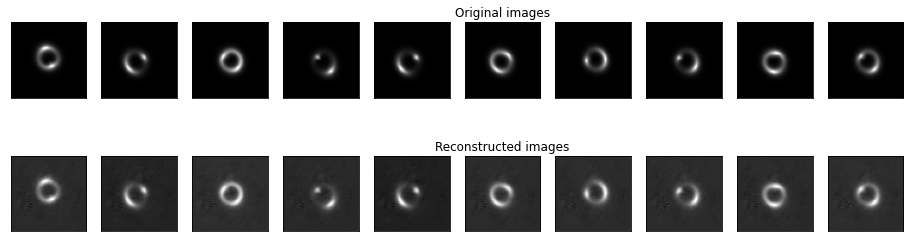

Epoch 52/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00018976072897203267, Val loss:0.0001580119860591367
Epoch 53/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00020605884492397308, Val loss:0.00025143727543763816
Epoch 54/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.000178382164449431, Val loss:8.606723713455722e-05
Epoch 55/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001824788050726056, Val loss:0.0001878755138022825
Epoch 56/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00017865427071228623, Val loss:0.00010368534276494756


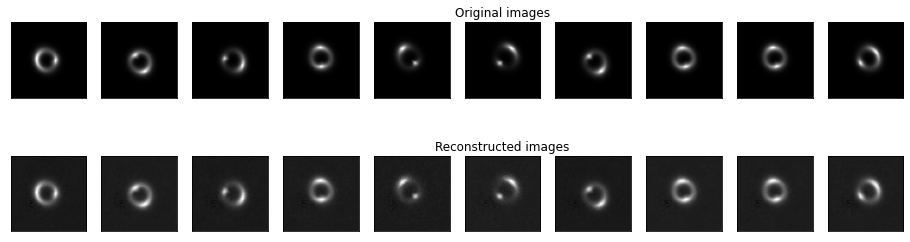

Epoch 57/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00017767060489859432, Val loss:0.00016447805683128536
Epoch 58/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001770126837072894, Val loss:0.00012314255582168698
Epoch 59/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001589784660609439, Val loss:0.0001757729478413239
Epoch 60/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001671865175012499, Val loss:8.695549331605434e-05
Epoch 61/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001752197276800871, Val loss:0.00011183347669430077


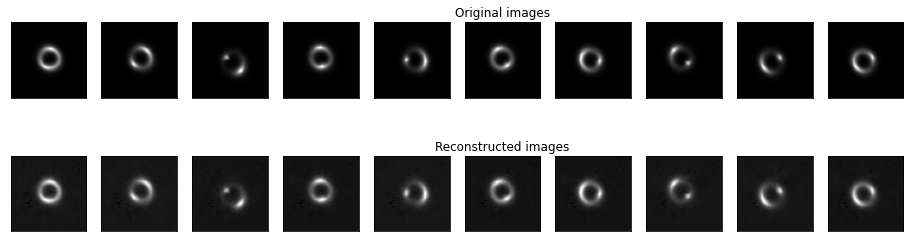

Epoch 62/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00013279942504595965, Val loss:8.407854329561815e-05
Epoch 63/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001591176842339337, Val loss:0.00020917641813866794
Epoch 64/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00014984438894316554, Val loss:7.353714318014681e-05
Epoch 65/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00014861552335787565, Val loss:0.00021258527704048902
Epoch 66/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001453347213100642, Val loss:7.500673382310197e-05


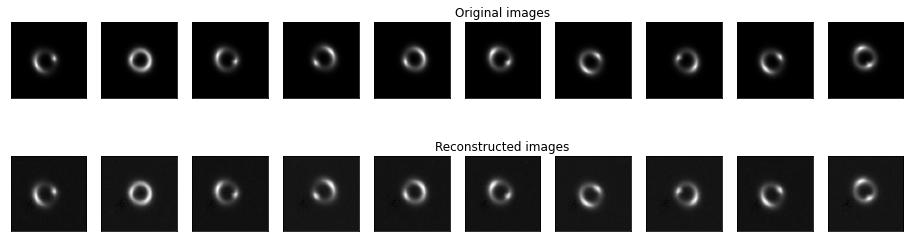

Epoch 67/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001232151553267613, Val loss:0.00017354855663143098
Epoch 68/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00013593555195257068, Val loss:7.694950909353793e-05
Epoch 69/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00012959702871739864, Val loss:0.00010590652527753264
Epoch 70/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001330890372628346, Val loss:6.56736665405333e-05
Epoch 71/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001396395091433078, Val loss:0.0001213375071529299


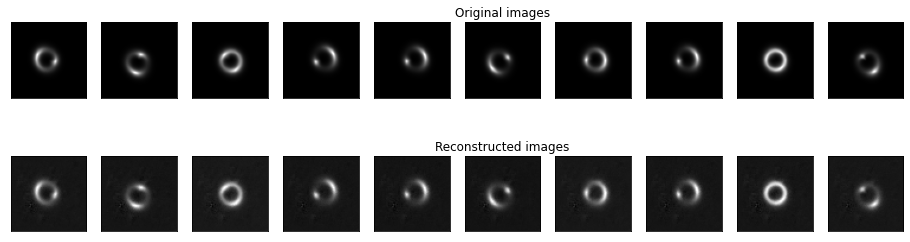

Epoch 72/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00012113781849620864, Val loss:6.184151425259188e-05
Epoch 73/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00013393712288234383, Val loss:0.00011564869055291638
Epoch 74/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00012856775720138103, Val loss:7.559572259197012e-05
Epoch 75/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00012124288332415745, Val loss:0.00012380475527606905
Epoch 76/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00011407631245674565, Val loss:7.379326416412368e-05


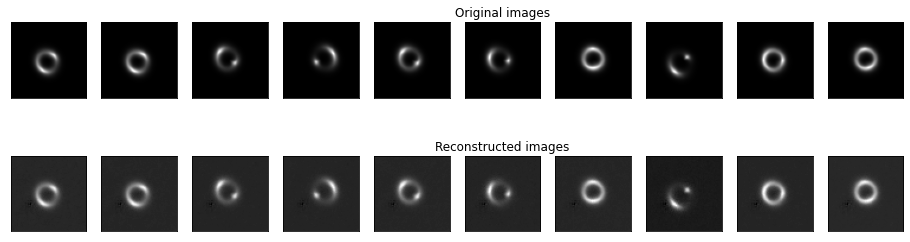

Epoch 77/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00011197675485163927, Val loss:0.0001376149448333308
Epoch 78/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.0001167082809843123, Val loss:7.190520409494638e-05
Epoch 79/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00011753571016015485, Val loss:0.00011025954154320061
Epoch 80/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00010569579171715304, Val loss:5.9049019910162315e-05
Epoch 81/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00010798269795486704, Val loss:0.00012314652849454433


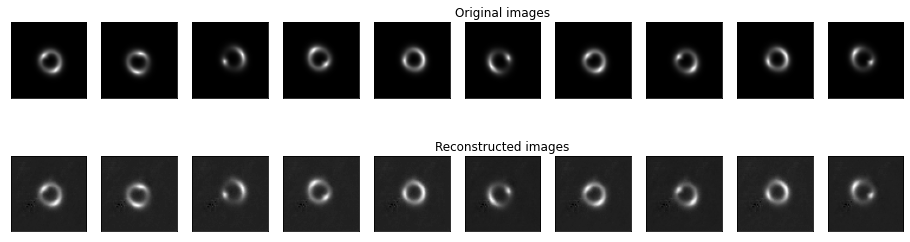

Epoch 82/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00012597562454175204, Val loss:8.721598715055734e-05
Epoch 83/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.880890138447285e-05, Val loss:0.00015367945889011025
Epoch 84/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00010186406871071085, Val loss:5.5436743423342705e-05
Epoch 85/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00011413254833314568, Val loss:8.867347060004249e-05
Epoch 86/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.26007705857046e-05, Val loss:6.617129110964015e-05


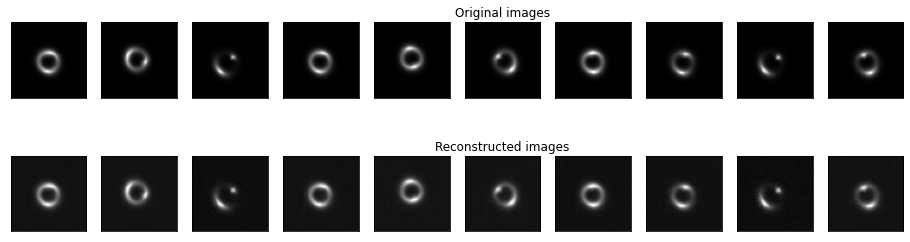

Epoch 87/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.11076131160371e-05, Val loss:9.709980804473162e-05
Epoch 88/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:0.00010512557491892949, Val loss:5.416034036898054e-05
Epoch 89/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.776620623189956e-05, Val loss:0.0001937759661814198
Epoch 90/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.70515757217072e-05, Val loss:4.592838013195433e-05
Epoch 91/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.44342027651146e-05, Val loss:9.05580454855226e-05


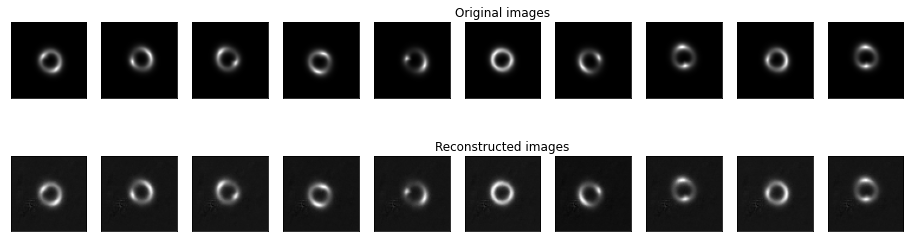

Epoch 92/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.274455467471853e-05, Val loss:5.6843316997401416e-05
Epoch 93/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:9.510969539405778e-05, Val loss:8.562823495594785e-05
Epoch 94/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.649462349945679e-05, Val loss:0.00011139862181153148
Epoch 95/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.536533277947456e-05, Val loss:0.00012034593237331137
Epoch 96/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.752681605983526e-05, Val loss:4.353975600679405e-05


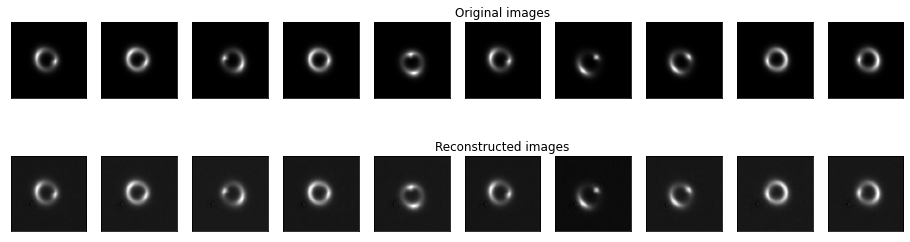

Epoch 97/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:7.41087642381899e-05, Val loss:7.438445754814893e-05
Epoch 98/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.20543646113947e-05, Val loss:6.84702827129513e-05
Epoch 99/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.154584793373942e-05, Val loss:7.723847375018522e-05
Epoch 100/100:


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train loss:8.011041063582525e-05, Val loss:4.9504444177728146e-05


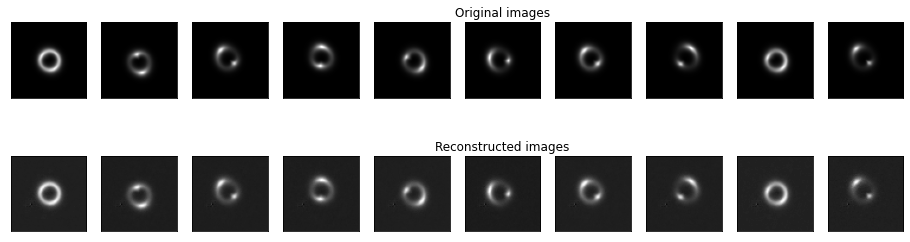

In [27]:
#Training and tracking model
model, loss_dict = fit_model(model, config)

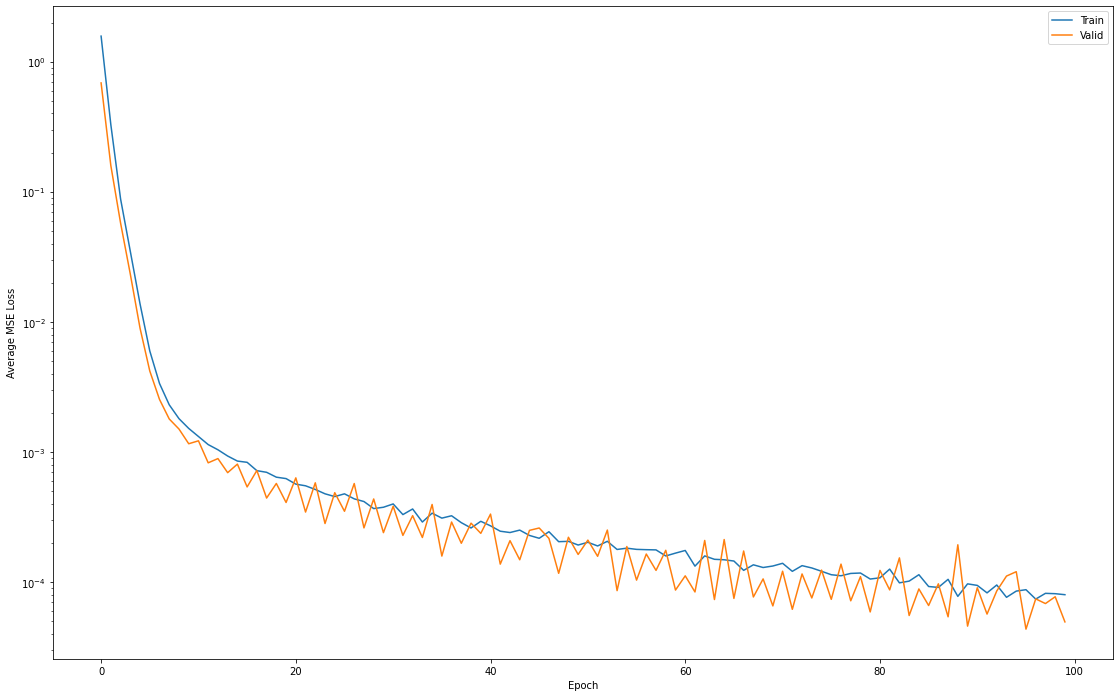

In [28]:
# Plot losses
plt.figure(figsize=(19,12))
plt.semilogy(loss_dict['train_loss'], label='Train')
plt.semilogy(loss_dict['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
#plt.grid()
plt.legend()
#plt.title('loss')


plot_name = "Loss_history"
plt.savefig(plot_name, format="png", dpi=80)  
pic = Image.open(plot_name)
wandb.log({plot_name: [wandb.Image(pic, caption = f"Train, Val MSE loss history")]})

plt.show()

In [29]:
PATH = "conv_AE.pth"
torch.save(model.state_dict(), PATH)

In [30]:
del model
gc.collect()

model = Autoencoder().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [31]:
criterion = nn.MSELoss()

_, _, train_mse = test_epoch(model, train_loader, criterion)
print("Train set MSE:" + str(train_mse))

_, _, val_mse = test_epoch(model, val_loader, criterion)
print("Val set MSE:" + str(val_mse))

_, _, test_mse = test_epoch(model, test_loader, criterion)
print("Test set MSE:" + str(test_mse))

  0%|          | 0/107 [00:00<?, ?it/s]

Train set MSE:6.087612e-05


  0%|          | 0/9 [00:00<?, ?it/s]

Val set MSE:4.9504444e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Test set MSE:4.951975e-05


In [32]:
scores = [[train_mse, val_mse, test_mse]]

wandb.log({"MSE_Scores": wandb.Table(data = scores, columns=["Train_MSE", "Val_MSE", "Test_MSE"])})

## Model Testing

In [33]:
def img_paths_list(root_dir):
    root_list = glob.glob(root_dir)
    class_map = {}
    class_distribution = {}
    
    for img_path in root_list:
        class_name = img_path.split(os.sep)[-2]
        if class_name not in class_distribution:
            class_distribution[class_name] = 1
        else:
            class_distribution[class_name] +=1
                
    for index, entity in enumerate(class_distribution):
        class_map[entity] = index
    print("Dataset Distribution:\n")
    print(class_distribution)
    print("\n\nClass indices:\n")
    print(class_map)

    data = []
    for img_path in tqdm(root_list):
        class_name = img_path.split(os.sep)[-2]
        data.append([img_path, class_name])
        
    return data, class_map

In [34]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_and_labels_list, class_map,transform = None):
        self.data = img_paths_and_labels_list
        self.class_map = class_map
        self.transform = transform
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = np.load(img_path, allow_pickle = True)
        if class_name == 'axion':
            img = img[0]
        img = (img - np.min(img))/(np.max(img) - np.min(img))
        
        if self.transform:
            aug = self.transform(image=img)
            img = aug['image']
        
        img = img.to(torch.float)
        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)

        return img, class_id

In [35]:
test_data_root_dir = r'../input/gsocml4scimodel2test/Model_II_test/*/*'
test_dataset_img_paths_list, class_map = img_paths_list(test_data_root_dir)

Dataset Distribution:

{'axion': 5000, 'no_sub': 5000, 'cdm': 5000}


Class indices:

{'axion': 0, 'no_sub': 1, 'cdm': 2}


  0%|          | 0/15000 [00:00<?, ?it/s]

In [36]:
test_dataset = CustomDataset(test_dataset_img_paths_list, class_map, transform = test_transforms)
print(len(test_dataset))

15000


In [37]:
test_loader = DataLoader(test_dataset, batch_size = config["batch_size"], shuffle = False, num_workers = 2)
single_batch = next(iter(test_loader))
single_batch[0].shape

torch.Size([256, 1, 64, 64])

In [38]:
def test_epoch(model, dataloader,criterion):

    model.eval()
    losses = []
    
    truth_list = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch, class_ids) in loop:
            
            for img, class_id in zip(img_batch,class_ids):
                
                if class_id == class_map['no_sub']:
                    truth_list.append(0)
                else:
                    truth_list.append(1)
                    
                img = img.unsqueeze(0)
                X = img.to(device)
                recon = model(X)
                loss = criterion(recon, X)
                losses.append(loss.detach().cpu().numpy())
                   

            
    return np.asarray(losses), np.asarray(truth_list), np.mean(losses)

In [39]:
criterion = nn.MSELoss()
loss_list, truth_list, mean_loss = test_epoch(model, test_loader,criterion)
print(mean_loss)

  0%|          | 0/59 [00:00<?, ?it/s]

9.746849e-05


In [40]:
fpr, tpr, thresholds = roc_curve(truth_list, loss_list)
roc_auc = auc(fpr, tpr)

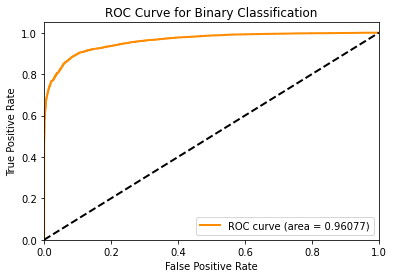

In [41]:
# Plot the AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend(loc="lower right", prop={"size":10})

plot_name = "ROC-AUC"
plt.savefig(plot_name, format="png", dpi=80)  
pic = Image.open(plot_name)
wandb.log({plot_name: [wandb.Image(pic, caption = f"ROC-AUC curve")]})

plt.show()

In [42]:
wandb.finish()